# Datasets & DataLoaders


データサンプルを処理するコードは煩雑になりやすく、メンテナンスも大変です。
読みやすさとモジュール化のために、学習のコードから切り離されることが理想です。  

PyTorchは2つのデータプリミティブを提供しています。PyTorch には ``torch.utils.data.DataLoader`` と ``torch.utils.data.Dataset`` という2つのデータプリミティブがあり、あらかじめ用意されたデータセットや独自のデータセットを利用することができます。  

``Dataset`` にはデータのサンプルとそれに対応するラベルが格納され、 ``DataLoader`` はサンプルに簡単にアクセスできるようにイテラブル（for文で1つずつ取り出せるように）にラップしています。  

PyTorchのライブラリには、いくつかのデータセット（FashionMNISTなど）が用意されていて、モデルのプロトタイプやベンチマークテストに使用することができます。  
※画像データセットは[こちら](https://pytorch.org/vision/stable/datasets.html)、自然言語データセットは
[こちら](https://pytorch.org/text/stable/datasets.html)、そして音声のデータセットは
[こちら](https://pytorch.org/audio/stable/datasets.html)を参考にしてください。


## データセットの読み込み

TorchVisionの[Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist/)データセットを読み込む例を見てみましょう。  

Fashion-MNISTは、Zalandoの記事画像のデータセットで、60,000の学習データと10,000のテストデータから構成されています。  
データは、28×28のグレースケール画像で、10クラスのうちの1つのラベルが付与されています。

[FashionMNIST Dataset](https://pytorch.org/vision/stable/datasets.html#fashion-mnist)を以下のパラメータでロードします。
 - ``root`` ：学習/テストデータが格納されているパス
 - ``train`` ：トレーニングデータセットまたはテストデータセットを指定
 - ``download`` ：`True`にするとルートディレクトリにデータがない場合にインターネットからデータをダウンロードしてくる
 - ``transform``:データの変換方法を指定
 - ``target_transform`` ：ラベルの変換方法を指定

In [22]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## データセットの反復処理と可視化

データセット ``Datasets`` から``training_data[index]`` のようにして、通常のリスト配列のように手動でデータを取得することができます。  
ここでは、 ``matplotlib`` を使用して、学習データのサンプルを可視化してみます。


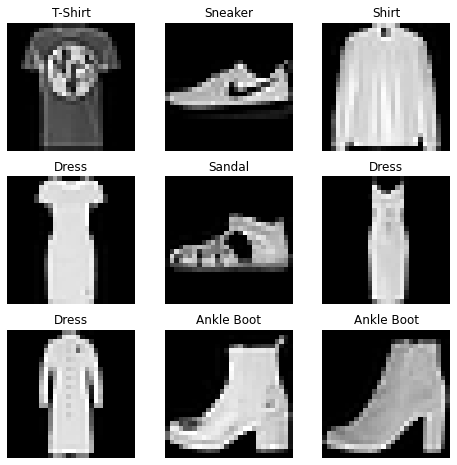

In [23]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## カスタムデータセットの作成

``Dataset``クラスを作成するためには、3つの関数を実装する必要があります。``__init__()``、``__len__()``、``__getitem__()`` の3つです。  

FashionMNISTの例をみてみましょう。
ここでは、画像データが格納されたディレクトリのパスを``img_dir``として与え、ラベルデータが記されたCSVファイルのパスを ``annotations_file``として与えます。

それぞれの関数の挙動について解説していきます。


In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### `__init__`関数

`__init__` 関数は、Dataset オブジェクトのインスタンスを作成する際に一度だけ実行されます。画像を格納しているディレクトリや教師データ、変換の方法（次のセクションで詳しく説明します）を初期化します。

なお、FashionMNISTの教師データのlabels.csvファイルの中身は次のようになっています。


    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9



In [ ]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

### ``__len__``関数

``__len__`` 関数は、データセットのサンプル数を返します。


In [ ]:
def __len__(self):
    return len(self.img_labels)

### ``__getitem__``関数

``__getitem__``関数は、データセットから指定されたインデックス ``idx`` にあるサンプルをロードして返します。  

このインデックスをもとに画像を検索し、 ``read_image`` を用いてテンソルへの変換を行い、 ``self.img_labels`` の csv データから対応するラベルを取得します。  


In [ ]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

## `DataLoader` を使った学習用のデータの準備

``Dataset`` クラスは、画像とラベルをセットとして一度に取得します。  

さて、モデルの学習では通常、モデルの過学習（オーバーフィッティング）を減らすために、エポック毎にデータをシャッフルします。ここで、Pythonの ``multiprocessing`` を使用してデータの取得を高速化します。

``DataLoader`` は上記の複雑な処理を簡単な API として抽象化したイテラブルです。


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## ``DataLoader`` のイテレート処理（繰り返し処理）

前述の処理でデータセットを ``DataLoader`` にロードしたので、必要に応じてデータセットを繰り返し処理することができます。

下記の反復処理では、 ``train_features`` と ``train_labels`` (``batch_size=64``なのでそれぞれ64個ずつの画像とラベルのセット) のバッチが返されます。

また、``shuffle=True`` を指定したため、すべてのバッチを繰り返し処理した後に（＝1エポック後に）、データの順番がシャッフルされます（データのロード順序をより細かく制御する場合は、[Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) を参照してください)。

In [ ]:
# Display image and label.
# 繰り返し実行
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# Transforms
機械学習アルゴリズムの学習に必要なデータは、必ずしも学習可能な状態へと加工されているわけではありません。

そこで`transforms`を使用して、データに何らかの処理を施し、学習可能な状態にします。

すべてのTorchVisionデータセットには2つのパラメータがあります。画像を処理するための``transform`` と
ラベルを処理するための ``target_transform``です。
[torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)モジュールによく使われる変換方法が実装されています。

さて、FashionMNISTの画像はPIL形式で、ラベルは整数値です。
学習させるためには、画像の数値を正規化してテンソル化して、ラベルをone-hotエンコードしてテンソル化する必要があります。
これらの変換を行うために、 ``ToTensor`` と ``Lambda`` を使います。



In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

## `ToTensor()`

[ToTensor](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor)
はPIL形式または NumPy の ``ndarray`` を ``FloatTensor`` に変換し、画像のピクセル値を [0., 1.] の範囲に正規化します。

## Lambda Transforms

ラムダ変換は、ユーザーが定義した任意のラムダ関数を適用します。  
ここでは、整数をone-hotエンコードされたテンソルに変換する関数
を定義します。
まず、サイズ10（データセットのラベル数と同じ数）で要素が全てゼロのテンソルを生成し[scatter_](https://pytorch.org/docs/stable/generated/torch.Tensor.scatter_.html)を呼び出します。
`scatter_`では ``y`` で与えられるインデックスに ``value=1`` を代入します。


In [ ]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

# ニューラルネットワークの構築

ニューラルネットワークはデータに対して演算を行う層/モジュールで構成されています。
[torch.nn](https://pytorch.org/docs/stable/nn.html)に独自のニューラルネットワークを構築するために必要な要素が実装されています。

また、PyTorchのすべてのモジュールは[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)をサブクラスとしています。

他のモジュールや層を使ってニューラルネットをモジュールとして構築することができます。
ニューラルネットをこのようにモジュールや層の入れ子構造で実装することで、複雑なアーキテクチャの構築や管理を容易にすることができます。

ここでは、FashionMNISTデータセットの画像を分類するためのニューラルネットワークを構築してみます。

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## `device`の確認

できればGPUのようなハードウェアアクセラレータを使ってモデルの学習を高速化したい．．．  
そんな時は[torch.cuda](https://pytorch.org/docs/stable/notes/cuda.html)が利用可能かどうか確認してみましょう。
`torch.cuda.is_available()`で利用可能か確認することができます。


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## クラスの定義
ニューラルネットワークを ``nn.Module`` のサブクラスとして定義します。 ``__init__``関数 でニューラルネットワークのレイヤーを初期化します。
また、入力データは``forward``関数 で処理します。

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

``NeuralNetwork`` のインスタンスを生成して ``device`` に転送し、その構造を表示させてみます。

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


モデルに入力データを渡すと ``forward``関数といくつかの [バックグラウンド処理](https://github.com/pytorch/pytorch/blob/270111b7b611d174967ed204776985cefca9c144/torch/nn/modules/module.py#L866) が呼び出されます。  
※ただし、``model.forward()`` のようにして直接`forward`関数を呼び出さないでください。

さて、`forward`関数を呼び出すと、各クラスの10個の予測値に対する生の出力がそれぞれの入力ごとに返されます。
このとき、(予測値、データインデックス)のようなデータ形式になっています。

この出力をさらに ``nn.Softmax`` モジュールのインスタンスに渡すして、ソフトマックス演算を行なって予測確率としています。

In [ ]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([3])


## モデルのレイヤー

FashionMNISTモデルのレイヤーを分解してみましょう。

縦横28x28のノイズ画像を3つ用意して、それをネットワークに通すとどうなるかをみてみます。

In [ ]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


### `nn.Flatten`
[nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)のオブジェクトを宣言します。
これを使って28x28の二次元のノイズ画像を784の一次元の配列に変換します。ここで、ミニバッチの次元(dim=0)は維持されます。



In [ ]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


### `nn.Linear`
[linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
は、保持している重みとバイアスを使用して入力されたデータに線形変換を適用するモジュールです。


In [ ]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


### `nn.ReLU`
活性化関数による非線形変換は、入力を複雑に変換させるためのものです。
線形変換の後に適用することで、非線形性を導入し、ニューラルネットワークが様々な現象を学習できるようにします。

ここでは例として[nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)を使用しますが、これ以外にも他に活性化関数はあります。

In [ ]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

### `nn.Sequential`
[nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)は、順番に並べられた
モジュールのコンテナです。ここで定義したモジュールを使って、ここで定義されたとおりの順序でデータを処理していきます。


In [ ]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

### `nn.Softmax`
ニューラルネットワークの最後の線形層は[-infty, \infty]の実数になっています。
ここでは出力を保持している`logits`を[nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) モジュールに渡します。ソフトマックス関数は与えられた行列の全ての値を[0,1]に、その合計を1にします。よって、ソフトマックス関数の出力を受け取った`pred_probab`は[0, 1]の値を持ち、それは各クラスに対するモデルの予測確率を表します。



In [ ]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

## モデルパラメータ
ニューラルネットワークの多くの層はパラメータ化されており、その重みとバイアスは学習によって最適化されていきます。  

``nn.Module`` のサブクラスは自動的にモデルオブジェクト内で定義されたすべての層を追跡し、すべてのパラメータにアクセスできる状態になります。
また、モデルの ``parameters()`` や ``named_parameters()`` メソッドを用いて、すべてのパラメータにアクセスすることもできます。

ここでは、各パラメータをイテレートし、そのサイズと値を表示してみます。




In [ ]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

# ``torch.autograd``を使った自動微分

ニューラルネットワークを学習させる際に、最もよく使われるアルゴリズムが**誤差逆伝播法**です。このアルゴリズムでは、パラメータ（モデルの重み）が損失関数の**勾配**にしたがって調整されます。

この勾配を計算するために、PyTorchは ``torch.authime`` という微分エンジンを内蔵しています。
これは、任意の計算グラフに対して勾配の自動計算を行うものです。

例として、パラメータ ``w`` と ``b`` 、そして何らかの損失関数を持つ、最も単純な 1 層のニューラルネットワークを考えてみましょう。これはPyTorch では次のように定義されます。

In [ ]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

## Tensors, Functions and Computational graph

このコードは、次のような**計算グラフ**を定義しています。

![図](https://pytorch.org/tutorials/_images/comp-graph.png)

このネットワークでは、``w`` と ``b`` が **パラメータ** であり、これを最適化する必要があります。
したがって、これらの変数に関する損失関数の勾配を計算できる必要があります。
そこで、テンソルの`requires_grad`プロパティを適用します。


``requires_grad`` の値は、テンソルを作成するときに設定するか、後で ``x.requires_grad_(True)`` のようにしてメソッドを使用して設定することができます。

テンソルに適用して計算グラフを構築する関数は、実際には ``Function`` クラスのオブジェクトです。

このオブジェクトは、順伝播の関数の計算方法と、誤差逆伝播時の微分の計算方法を保持しています。誤差逆伝播法の関数の情報は、テンソルの ``grad_fn`` プロパティに格納されています。 ``Function`` 自体の詳細については、[ドキュメント](https://pytorch.org/docs/stable/autograd.html#function)を参照してください。


In [ ]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x17ed279d0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x17ed27e80>


## 勾配の計算

ニューラルネットワークのパラメータの重みを最適化するためには、損失関数のパラメータに関する導関数を計算する必要があります。つまり、任意の変数 ``x``と``y``のに対して、$\frac{\partial loss}{\partial w}$ と $\frac{\partial loss}{\partial b}$ が必要です。
これらの導関数を計算するために、 ``loss.backward()`` を呼び出し、 ``w.grad`` と ``b.grad`` から値を取得する必要があります。



In [ ]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2489, 0.3117, 0.3249],
        [0.2489, 0.3117, 0.3249],
        [0.2489, 0.3117, 0.3249],
        [0.2489, 0.3117, 0.3249],
        [0.2489, 0.3117, 0.3249]])
tensor([0.2489, 0.3117, 0.3249])


## 勾配計算の追跡カット

デフォルトでは、 ``requires_grad=True`` のテンソルはすべて計算履歴を追跡し、勾配計算をサポートします。  

しかし、その必要がない場合もあります。  
例えば、学習後のモデルにデータを入力したいだけの場合、つまり、ニューラルネットワークを通して順伝播計算だけを行いたいという場合である。
この場合は、計算コードを ``torch.no_grad()`` ブロックで囲むことで、トラッキング計算を停止させることができます。




In [ ]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


別の方法として、テンソルに対して ``detach()`` メソッドを使用すること方法もあります。




In [ ]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


勾配のトラッキングを無効にした方がいい理由はこの通りです。
  - ニューラルネットワークのいくつかのパラメータを固定するため。これは[再学習](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)のために必須な処理です
  - 勾配を追跡しないテンソルの計算の方が効率が良いことを利用して、順伝播だけを行う場合は高速化させるため


## 計算グラフについて
概念的には、autogradはデータ(テンソル)と実行されたすべての操作(結果の新しいテンソルも含む)の記録を
[Function](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function) オブジェクトからなる有向非循環グラフ (Directed Acyclic Graph, DAG) に記録します。

この DAG において、葉は入力テンソル、根は出力テンソルに該当します。そして、このグラフを根から葉までたどれば、連鎖律を使って自動的に勾配を計算することができます。

順伝播計算において、autogradは同時に2つのことを行います。

- 演算を実行し、結果のテンソルを計算する
- DAGの中で操作の勾配関数を維持する

誤差逆伝播は ``.backward()`` がDAGの根本から呼び出された時に計算されます。その後で ``autograd`` が呼び出されます。

- 各 ``.grad_fn`` から勾配を計算する
- 各テンソルの ``.grad`` 属性に勾配計算の結果を蓄積する
- 連鎖律を使って葉となるテンソルまで伝播させる


## おまけ: テンソル勾配とヤコビアン積

多くの場合，スカラーで計算する損失関数があり，あるパラメータに対する勾配をそれぞれ別個で計算する必要があります．
しかし、出力関数が任意のテンソルになっている場合があります。このような場合、PyTorch では、実際の勾配ではなく、いわゆる **ヤコビアン積** を計算することができます。

$\vec{x}=\langle x_1,\dots,x_n\rangle$ と $\vec{y}=\langle y_1,\dots,y_m\rangle$とする、ベクトル関数 $\vec{y}=f(\vec{x})$ の $\vec{x}$ に対する $\vec{y}$ の勾配は **ヤコビアン行列**で与えられます。

\begin{align}J=\left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\end{align}


PyTorchでは、ヤコビアン行列そのものを計算する代わりに、与えられた入力ベクトル $v=(v_1 \dots v_m)$ に対する **ヤコビアン積** $v^T\cdot J$ を計算することが可能です。  
これは、$v$を引数として ``backward`` を呼び出すことで実現されます。 なお、$v$ のサイズは、積を計算したい元のテンソルのサイズと同じでなければなりません。


In [ ]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

ここで、同じ引数で2回目の ``backward`` を呼び出したとき、勾配の値が異なることに注意してください。  
これは、 ``backward`` 伝搬を行う際に、PyTorch が **勾配を累積する** ためです。  
つまり、計算された勾配の値は、計算グラフのすべての葉となるノードの ``grad`` に追加されることになります。
適切な勾配を計算したい場合は、事前に ``grad`` をゼロにする必要があります。
実際の学習では、`optimizer` を使って処理していきます。

以前は ``backward()`` 関数をパラメータなしで呼び出していました。
これは本質的には ``backward(torch.tensor(1.0))`` を呼び出すことと同じで、ニューラルネットワークの学習における損失のようにスカラー値を持つ関数を使う場合に、勾配計算を簡単に行うことができます。




# モデルパラメータの最適化

モデルとデータが揃ったので、次はデータに対してモデルのパラメータを最適化することで、モデルを学習、検証、テストしていきます。

モデルの学習は反復プロセスです。  
各反復において、モデルは出力値を推測し、その推測と教師データとの誤差（*損失*）を計算します。  
前述の通り、その誤差のパラメータに対する導関数を蓄積しておき、勾配降下法によってこれらのパラメータを**最適化**します。

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

## ハイパーパラメータ

ハイパーパラメータは、モデルの最適化プロセスを制御するための調整可能なパラメーターです。ハイパーパラメータの値を変えることで、モデルの学習や収束率を制御することができます（ハイパーパラメータのチューニングについては[こちら](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)をご覧ください）。

ここでは、学習用のハイパーパラメータを以下のように定義します。
 - **エポック数**： データセットに対して反復処理を行う回数
 - **バッチサイズ**： パラメータを更新するために一度に渡されるデータサンプルの個数
 - **学習率**： - 各バッチ/エポックにおいて、モデルのパラメータをどれだけ更新するかの比率。小さい値を設定すると学習速度が遅くなり、大きい値を設定すると学習時に予測不可能な挙動をする可能性がある




In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

## 最適化ループ

ハイパーパラメータを設定したら、ループ処理でモデルを学習し最適化することができます。ループ処理の各反復は、**エポック**と呼ばれます。

エポックは主に2つの部分から構成されています。
 - **学習ループ**： 学習データセットを繰り返し、最適なパラメータに収束させる
 - **検証/テストループ**： テストデータセットを繰り返し処理し、モデルの性能が向上しているかどうかを確認する

学習ループで使われるいくつかの用語について簡単に説明します。

### 損失関数

あるデータを入力したとき、学習前のニューラルネットワークは答えが間違っている可能性が高いです。  
**損失関数**は、得られた結果と目標値との違いを測定するもので、学習を繰り返して最小化を目指します。  
損失を計算するために、与えられたデータサンプルの入力を使って予測を行い、真のデータ・ラベルの値と比較します。

一般的な損失関数は回帰タスクの[nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) (Mean Square Error)、分類の[nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) (Negative Log Likelihood)などです。
[nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) は ``nn.LogSoftmax`` と ``nn.NLLoss`` を結合したものです。

モデルの出力を ``nn.CrossEntropyLoss`` に渡すと、値が正規化されて予測誤差が計算されます。

In [ ]:
# 損失関数の初期化
loss_fn = nn.CrossEntropyLoss()

### 最適化器

最適化とは、各学習ステップにおいて、モデルの誤差を減らすためにモデルのパラメータを調整する処理です。  
**最適化アルゴリズム** は、このプロセスの実行方法を定義します（この例では、確率的勾配降下法, Stochastic Gradient Descent, SGD を使用します）。  
最適化ロジックは ``optimizer`` オブジェクトにカプセル化されています。  
今回はSGDを使用しますが、PyTorchにはADAMやRMSPropなど多くの[異なる最適化器](https://pytorch.org/docs/stable/optim.html)があります。

学習が必要なモデルのパラメータを登録し、学習率ハイパーパラメータを渡すことで最適化器を初期化します。


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

学習ループの内部では、3つのステップで最適化が行われます。
- モデルパラメータの勾配をリセットするために ``optimizer.zero_grad()`` を呼び出します。勾配は加算されていくので、二重計算を防ぐために各反復で明示的にゼロにする必要があります
- 予測損失は ``loss.backward()`` を呼び出すと誤差逆伝播します。また、PyTorchは、各パラメータに対する損失の勾配を記録しています
- 勾配が得られたら、 ``optimizer.step()`` を呼び出して、誤差逆伝播で収集した勾配を元にパラメータを調整します



## 最適化の実装の全体像
最適化コードをループする ``train_loop`` と、テストデータに対してモデルの性能を評価する ``test_loop`` を定義します。



In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

損失関数と最適化器を宣言し、 ``train_loop`` と ``test_loop`` に渡します。  
ここで、エポック数を増やしてみましょう。  
モデルの性能が向上していることを自由に確認することをできます。

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

## 損失関数
- [Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)


### MSELoss




入力$x$とターゲット$y$の各要素間の平均二乗誤差（L2ノルムの二乗）を測定する基準を作成します。

次元を維持する（reduction='none'）場合は、以下のように記述することができます。ここで $N$ はバッチサイズです。

$\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = \left( x_n - y_n \right)^2$ 

reductionを'none' ではない場合(デフォルトは'mean')は以下のように記述できます。

$\ell(x, y) = \begin{cases} \operatorname{mean}(L), & \text{if reduction} = \text{`mean';}\\ \operatorname{sum}(L), & \text{if reduction} = \text{`sum'.} \end{cases}$
 
$x$と$y$はそれぞれ合計$n$個の要素を持つ任意の形のテンソルです。

平均演算はやはり全要素に対して行われ、$n$で除算されます。

reduction = 'sum' とすれば，$n$による除算を避けることができます。



### NLLLoss



負の対数尤度損失（Negative Log Likelihood Loss）。C個のクラスからなる分類問題を学習するのに有用です。

オプションの引数 weight は、各クラスに重みを割り当てる 1次元テンソルでなければなりません。  
これは，アンバランスな学習セットを持っている場合に特に有用です。

inputは、( $minibatch, C$ )または( $minibatch, C, d_1, d_2, ..., d_K$ )のいずれかのサイズのTensorでなければならず、K次元の場合は $K \geq 1$ でなければなりません。  
後者は、2次元画像の画素あたりのNLLLOSSを計算するような高次元の入力に有効です。

ニューラルネットワークで対数確率を得るには、ネットワークの最後の層にLogSoftmax層を追加することで簡単に実現できます。  
余分なレイヤーを追加したくない場合は、代わりにCrossEntropyLossを使用することができます。 

この損失が期待するターゲットは、$[0, C-1]$ (C = クラス数) の範囲にあるクラスインデックスでなければなりません。

また、ignore_indexが指定された場合、この損失はこのクラスインデックスを受け付けます (このインデックスは必ずしもクラスの範囲内でなくても構いません)。

$x$がinput, $y$がtarget, $w$がweight, $N$はバッチサイズ.

$\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - w_{y_n} x_{n,y_n}, \quad w_{c} = \text{weight}[c] \cdot \mathbb{1}\{c \not= \text{ignore\_index}\}$,

reductionを'none' ではない場合(デフォルトは'mean')は以下のように記述できます。

$\ell(x, y) = \begin{cases} \sum_{n=1}^N \frac{1}{\sum_{n=1}^N w_{y_n}} l_n, & \text{if reduction} = \text{`mean';}\\ \sum_{n=1}^N l_n, & \text{if reduction} = \text{`sum'.} \end{cases}$


### CrossEntropyLoss



入力ロジットとターゲット間のクロスエントロピーの損失を計算します。

これは、C個のクラスを持つ分類問題を学習するときに有用です。  
オプションの引数weightは、各クラスに重みを割り当てる1次元テンソルでなければなりません。  
これは、アンバランスな学習セットを持っている場合に特に有用です．

入力は、各クラスの非正規化ロジット（一般に、正であったり、和が1になる必要はない）を含むことが期待されます。  
inputは、バッチされていないinputではサイズ ($C$)、K次元の場合には$Kを1$とした ($minibatch, C$) または ($minibatch, C, d_1, d_2, ..., d_K$) のTensorでなければなりません。  
また、2次元画像のピクセル毎のクロスエントロピー損失を計算するような高次元の入力に有用です。

以下のいずれかを含むことが想定されています。

- $[0, C)$ ($C$ はクラス数); ignore_index が指定された場合、この損失はこのクラスインデックスも受け入れます（このインデックスは必ずしもクラス範囲内にあるとは限りません）。この場合の未削減(つまり削減を'なし'に設定した場合)の損失は次のように記述できます。

  ここで$x$は入力、$y$はターゲット、$w$は重み、$C$はクラス数、$N$はミニバッチ次元と$K$次元の場合の$d_1, ..., d_{kd}$にまたがるものである。
    
  $\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - w_{y_n} \log \frac{\exp(x_{n,y_n})}{\sum_{c=1}^C \exp(x_{n,c})}\cdot \mathbb{1}\{y_n \not= \text{ignore\_index}\}$

  reductionが'none'でない場合(デフォルトは'mean')は以下のように記述できる。

  $\ell(x, y) = \begin{cases} \sum_{n=1}^N \frac{1}{\sum_{n=1}^N w_{y_n} \cdot \mathbb{1}\{y_n \not= \text{ignore\_index}\}} l_n, & \text{if reduction} = \text{`mean';}\\ \sum_{n=1}^N l_n, & \text{if reduction} = \text{`sum'.} \end{cases} $
 
  この場合、LogSoftmaxとNLLLossの組み合わせと同等であることに注意してください。

- 各クラスの確率；混合ラベル、ラベルスムージングなど、ミニバッチアイテムごとに単一クラス以上のラベルが必要な場合に有用です。この場合の未削減（つまり、削減を「なし」に設定した場合）の損失は、次のように記述できます。

  ここで、$x$は入力、$y$はターゲット、$w$は重み、$C$はクラス数、$N$はミニバッチ次元とK次元の場合の$d_1, ..., d_kd$にまたがります。

  $\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \sum_{c=1}^C w_c \log \frac{\exp(x_{n,c})}{\sum_{i=1}^C \exp(x_{n,i})} y_{n,c}$​

  reductionが'none'でない場合(デフォルトは'mean')は以下のように記述できます。

  $\ell(x, y) = \begin{cases} \frac{\sum_{n=1}^N l_n}{N}, & \text{if reduction} = \text{`mean';}\\ \sum_{n=1}^N l_n, & \text{if reduction} = \text{`sum'.} \end{cases}$